In [102]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomTranslation, RandomContrast

In [63]:
# Instantiate augmentation layers once
aug_flip     = RandomFlip("horizontal")
aug_rot      = RandomRotation(0.1)    # ±10%
aug_zoom     = RandomZoom(0.1)        # ±10%
aug_contrast = RandomContrast(0.1)    # ±10%

In [64]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True,
                                  max_num_faces=1,
                                  refine_landmarks=True)

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Concatenate,
    Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast
)
from keras_facenet import FaceNet


I0000 00:00:1745975623.358747 4330124 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 76.3), renderer: Apple M1
W0000 00:00:1745975623.496759 5372410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745975623.525117 5372410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [65]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) UTILS: Dlib‑68 ↔ MediaPipe FaceMesh index map
#    (from alex1779’s SO answer) :contentReference[oaicite:0]{index=0}
# ─────────────────────────────────────────────────────────────────────────────
DLIB_68_TO_MESH = {
    0: 162,  1: 234,  2: 93,   3: 58,   4: 172,  5: 136,  6: 149,  7: 148,
    8: 152,  9: 377, 10: 378, 11: 365, 12: 397, 13: 288, 14: 323, 15: 454,
   16: 389, 17:  71, 18:  63, 19: 105, 20:  66, 21: 107, 22: 336, 23: 296,
   24: 334, 25: 293, 26: 301, 27: 168, 28: 197, 29:   5, 30:   4, 31:  75,
   32:  97, 33:   2, 34: 326, 35: 305, 36:  33, 37: 160, 38: 158, 39: 133,
   40: 153, 41: 144, 42: 362, 43: 385, 44: 387, 45: 263, 46: 373, 47: 380,
   48:  61, 49:  39, 50:  37, 51:   0, 52: 267, 53: 269, 54: 291, 55: 405,
   56: 314, 57:  17, 58:  84, 59: 181, 60:  78, 61:  82, 62:  13, 63: 312,
   64: 308, 65: 317, 66:  14, 67:  87
}

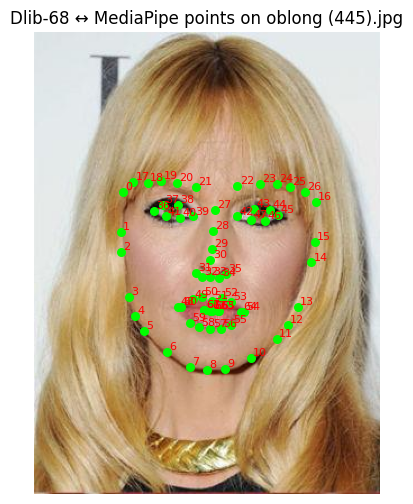

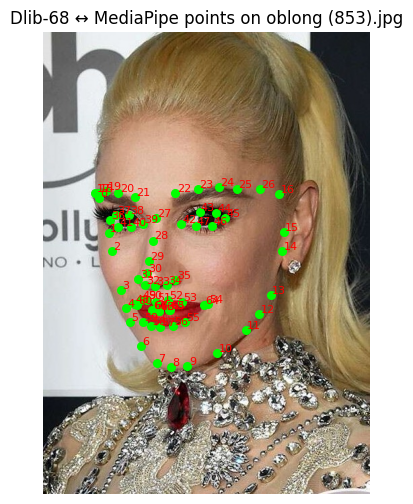

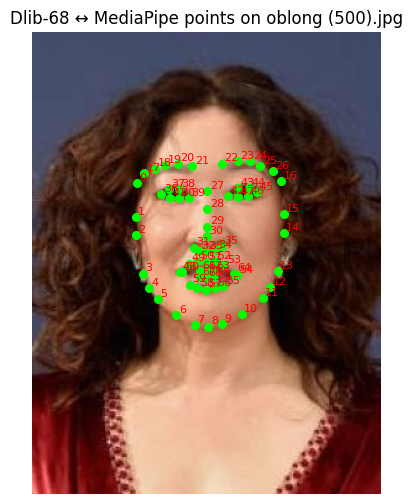

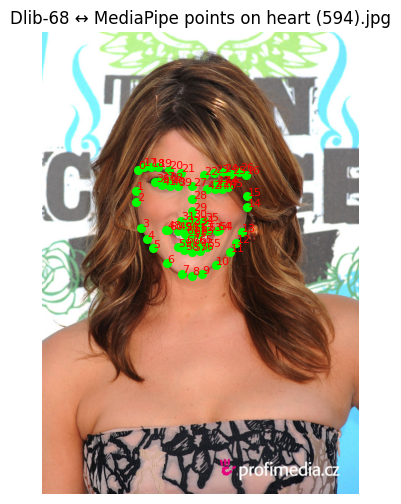

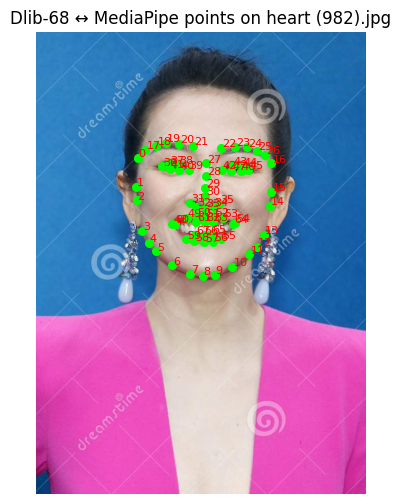

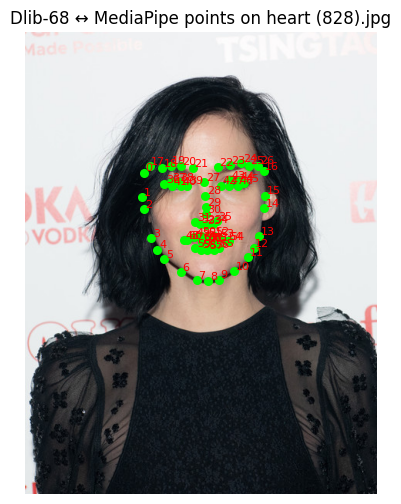

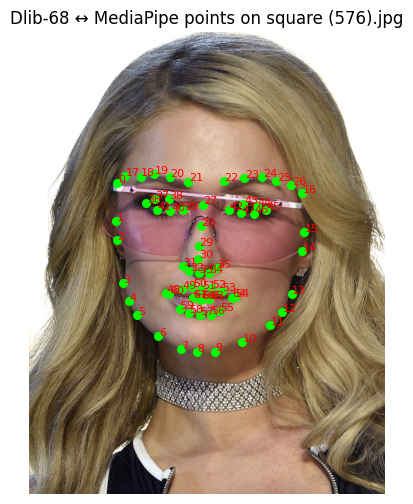

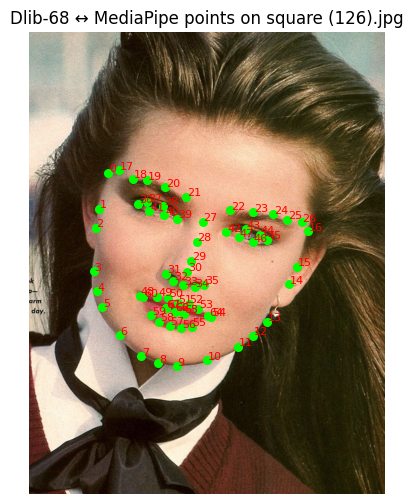

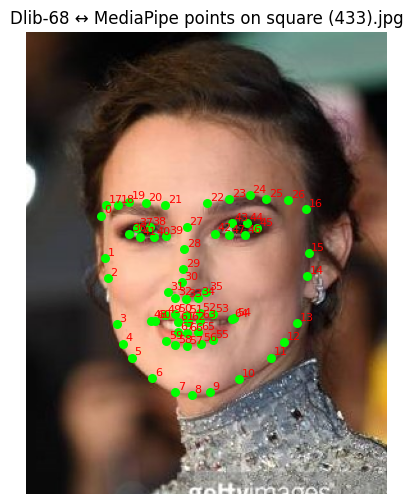

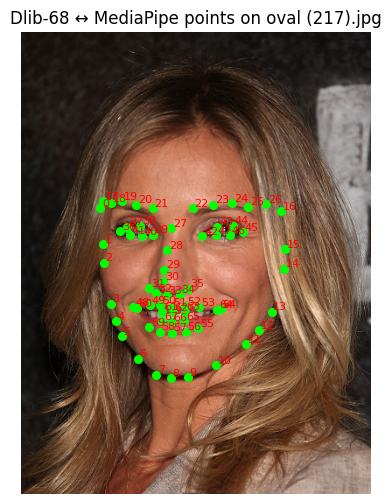

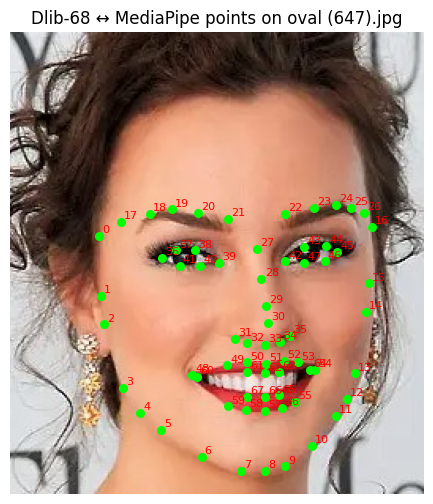

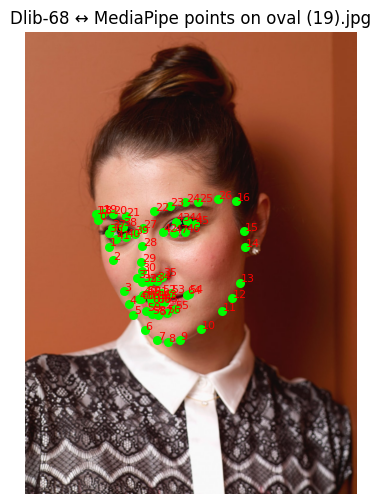

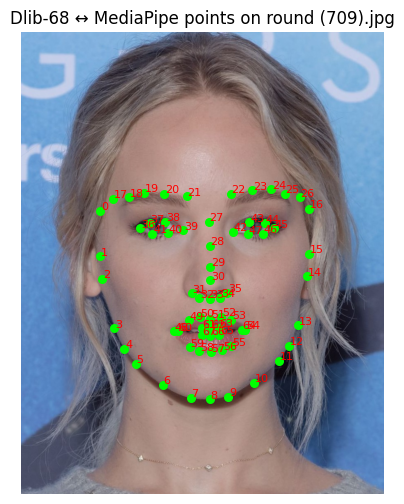

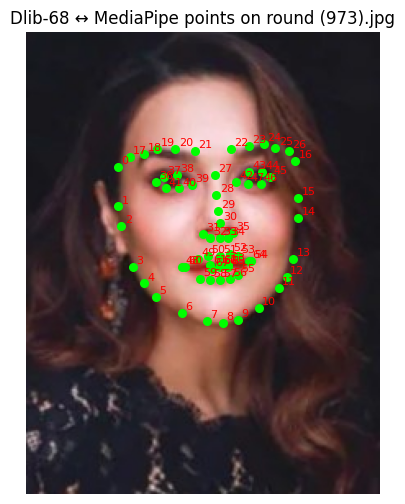

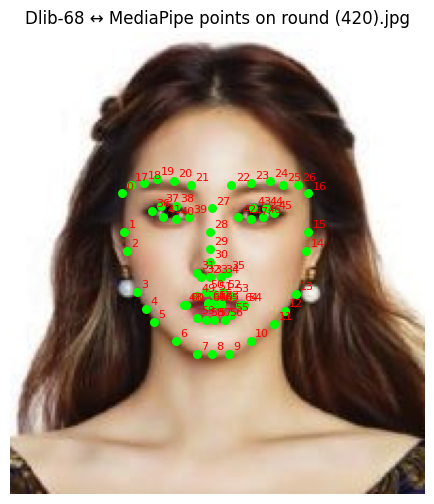

In [66]:
import matplotlib.pyplot as plt

def visualize_dlib68_mapping(image_path):
    """
    Load an image, detect the MediaPipe 468 landmarks,
    then overlay just the 68 Dlib‑mapped points with their indices.
    """
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"[!] Could not read {image_path}")
        return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    # 1) initial mesh on raw
    res = face_mesh.process(img_rgb)
    if not res.multi_face_landmarks:
        print("[!] No face detected.")
        return
    mesh = res.multi_face_landmarks[0].landmark
    h, w = img_bgr.shape[:2]

    # 2) plot
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    for dlib_idx, mesh_idx in DLIB_68_TO_MESH.items():
        x = int(mesh[mesh_idx].x * w)
        y = int(mesh[mesh_idx].y * h)
        plt.scatter(x, y, s=30, c='lime', marker='o')
        plt.text(x+2, y-2, str(dlib_idx), color='red', fontsize=8)
    plt.axis('off')
    plt.title(f"Dlib‑68 ↔ MediaPipe points on {os.path.basename(image_path)}")
    plt.show()


# ──────────────── USAGE EXAMPLE ────────────────────
# After your main imports and definitions, try:
DATA_ROOT = "/Users/dikshatiwari/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/"
CLASSES   = ['Oblong','Heart','Square','Oval','Round']

for cls in CLASSES:
    folder = os.path.join(DATA_ROOT, cls)
    # show only first 3 examples per class
    for fname in os.listdir(folder)[:3]:
        full_path = os.path.join(folder, fname)
        visualize_dlib68_mapping(full_path)

In [67]:
# ─────────────────────────────────────────────────────────────────────────────
# 2) FACE ALIGNMENT (rotate + no scale)
# ─────────────────────────────────────────────────────────────────────────────
def get_eye_center(landmarks, idxs):
    pts = np.array([[landmarks[i].x, landmarks[i].y] for i in idxs])
    return pts.mean(axis=0)

def align_face_no_scale(img_bgr, landmarks):
    """
    Rotate so eyes are horizontal, but do NOT scale.
    Returns rotated BGR image and eye‑midpoint in pixel coords.
    """
    h, w = img_bgr.shape[:2]
    left  = get_eye_center(landmarks, [33,133])  # outer/inner left eye
    right = get_eye_center(landmarks, [362,263])
    dx, dy = (right - left)
    angle  = np.degrees(np.arctan2(dy, dx))
    eye_mid = ((left + right)/2) * np.array([w, h])
    M = cv2.getRotationMatrix2D(tuple(eye_mid), angle, 1.0)
    rotated = cv2.warpAffine(img_bgr, M, (w, h),
                             flags=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)
    return rotated, tuple(eye_mid.astype(int))

In [68]:
# ─────────────────────────────────────────────────────────────────────────────
# 3) HAND‑CRAFTED FEATURES: landmarks68 + geometric + HOG
# ─────────────────────────────────────────────────────────────────────────────
def compute_geometry(pts68_pixel):
    """Compute the 9 geometry features from 68 landmarks in pixel coords."""
    def dist(i,j): return np.linalg.norm(pts68_pixel[i] - pts68_pixel[j])
    face_h = dist(27, 8)                                     # nose‑bridge → chin
    fore_w = dist(19, 24)                                    # brow corner → brow corner
    cheek_w= dist(4, 12)                                     # jaw left → jaw right
    jaw_w  = cheek_w
    eye_c  = (pts68_pixel[36] + pts68_pixel[45]) / 2          # avg eye center
    eye_ch = np.linalg.norm(eye_c - pts68_pixel[8])          # eye→chin
    nose_ch= dist(30, 8)                                     # nose tip→chin
    jaw_ang= np.degrees(np.arccos( 
              np.dot(pts68_pixel[4]-pts68_pixel[8],
                     pts68_pixel[12]-pts68_pixel[8]) /
              (np.linalg.norm(pts68_pixel[4]-pts68_pixel[8]) *
               np.linalg.norm(pts68_pixel[12]-pts68_pixel[8])) ))
    r1 = face_h / cheek_w if cheek_w else 0
    r2 = fore_w / jaw_w   if jaw_w   else 0
    return np.array([face_h, fore_w, cheek_w, jaw_w, eye_ch,
                     nose_ch, jaw_ang, r1, r2], dtype=np.float32)


In [69]:
def extract_handcrafted(img_bgr):
    """
    1) detect & rotate (no scale)
    2) detect landmarks on rotated
    3) crop around eye midpoint (fixed window)
    4) compute 68‑point landmarks, geometry & HOG
    """
    # Step A: initial mesh & rotate
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    res0 = face_mesh.process(img_rgb)
    if not res0.multi_face_landmarks: return None, None
    lm0 = res0.multi_face_landmarks[0].landmark
    rot, eye_mid = align_face_no_scale(img_bgr, lm0)

    # Step B: re‑detect mesh on rotated frame
    res1 = face_mesh.process(cv2.cvtColor(rot, cv2.COLOR_BGR2RGB))
    if not res1.multi_face_landmarks: return None, None
    lm1 = res1.multi_face_landmarks[0].landmark

    # Step C: pixel‑coords of Dlib‑68
    h, w = rot.shape[:2]
    pts68 = np.array([
        (lm1[DLIB_68_TO_MESH[i]].x * w,
         lm1[DLIB_68_TO_MESH[i]].y * h)
        for i in range(68)
    ], dtype=np.float32)

    # Step D: fixed crop around eye‑midpoint
    # … after you compute 'rot' (rotated image) and 'eye_mid'
    # Step D: fixed crop around eye‑midpoint (pixel‑coords)
    ew = int(min(w, h) * 0.8)
    eh = int(ew * 1.2)
    x0 = max(0, eye_mid[0] - ew//2)
    y0 = max(0, eye_mid[1] - int(eh*0.4))
    crop = rot[y0:y0+eh, x0:x0+ew]
    if crop.size == 0:
        return None, None
    
    # ← NEW: resize to a canonical size so HOG is consistent
    canonical = (224, 224)       # or (160,160), whatever you choose
    crop_resized = cv2.resize(crop, canonical, interpolation=cv2.INTER_LINEAR)

    # Step E: HOG on the fixed‑size patch
    gray = cv2.cvtColor(crop_resized, cv2.COLOR_BGR2GRAY)
    hog_feats = hog(
        gray,
        orientations=9,
        pixels_per_cell=(16,16),
        cells_per_block=(2,2),
        block_norm='L2-Hys',
        feature_vector=True
    )
    # Step F: geometry on your 68 pts (unchanged)
    geom_feats = compute_geometry(pts68)

    # Finally—flatten the Dlib‐68 coords, concat geom + HOG
    flat68 = pts68.flatten()
    hand = np.hstack([flat68, geom_feats, hog_feats]).astype(np.float32)
    
    return hand, crop

In [70]:
def build_cnn_branch(freeze_until_last_n=10):
    """
    Loads the FaceNet embedding model via keras-facenet,
    then freezes all layers except the last `freeze_until_last_n` layers.
    Returns a Keras Model mapping (160,160,3) -> (512,).
    """
    # 1) Instantiate the FaceNet model
    embedder = FaceNet()          # uses the 160×160 input by default
    base_model = embedder.model   # This is a tf.keras.Model

    # 2) Freeze all but the last `freeze_until_last_n` layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[: total_layers - freeze_until_last_n]:
        layer.trainable = False
    for layer in base_model.layers[ total_layers - freeze_until_last_n :]:
        layer.trainable = True

    return base_model

In [72]:
def prepare_cnn_input(crop_bgr):
    rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb, (160,160), interpolation=cv2.INTER_LINEAR)
    return resized.astype(np.float32) / 255.0

In [91]:
# ───────────────────────────────────────────────────────────────
# 3) tf.data pipeline with optional augmentation
# ───────────────────────────────────────────────────────────────
def create_two_branch_dataset(X_imgs, X_hands, y, batch_size=16, augment=False):
    """
    Yields ((img, hand), label) tuples.
    If augment=True, applies random flip/rotate/zoom/contrast to img.
    """
    ds = tf.data.Dataset.from_tensor_slices((X_imgs, X_hands, y))
    ds = ds.shuffle(len(y), reshuffle_each_iteration=True)

    def _prep(img, hand, label):
        if augment:
            img = aug_flip(img)
            img = aug_rot(img)
            img = aug_zoom(img)
            img = aug_contrast(img)
            # optional brightness jitter
            img = tf.image.random_brightness(img, 0.1)
        # return (img, hand), label
        return img, label

    ds = ds.map(_prep, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [90]:
# ───────────────────────────────────────────────────────────────
# 4) Hybrid model definition
# ───────────────────────────────────────────────────────────────
def build_hybrid_model(n_hand_feats, num_classes=5):
    # Image branch
    img_in = Input((160,160,3), name='img_in')
    cnn_base = build_cnn_branch(freeze_until_last_n=10)
    x = cnn_base(img_in)            # → (None,512)
    x = Dense(512, activation='relu',
              kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu',
              kernel_regularizer=regularizers.l2(1e-4))(x)
    x = Dropout(0.5)(x)

    # # Hand‑crafted branch
    # hand_in = Input((n_hand_feats,), name='hand_in')
    # y_branch = Dense(256, activation='relu',
    #                  kernel_regularizer=regularizers.l2(1e-4))(hand_in)
    # y_branch = Dropout(0.5)(y_branch)

    # # Fuse & head
    # merged = Concatenate(name='fusion')([x, y_branch])
    # z = Dense(256, activation='relu',
    #           kernel_regularizer=regularizers.l2(1e-4))(merged)
    # z = Dropout(0.5)(z)
    # out = Dense(num_classes, activation='softmax', name='preds')(z)
    out = Dense(num_classes, activation='softmax', name='preds')(x)

    model = Model(img_in, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [92]:
# ───────────────────────────────────────────────────────────────
# 5) Example training loop
# ───────────────────────────────────────────────────────────────
if __name__ == "__main__":
    DATA_ROOT = "/Users/dikshatiwari/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/"
    CLASSES   = ['Oblong','Heart','Square','Oval','Round']

    X_img, X_hand, y = [], [], []
    for cls in CLASSES:
        for fn in os.listdir(os.path.join(DATA_ROOT,cls)):
            img = cv2.imread(os.path.join(DATA_ROOT,cls,fn))
            if img is None: continue
            hand, crop = extract_handcrafted(img)
            if hand is None: continue

            X_img.append(prepare_cnn_input(crop))
            X_hand.append(hand)
            y.append(CLASSES.index(cls))

    X_img  = np.stack(X_img, axis=0)
    X_hand = np.stack(X_hand, axis=0)
    y      = np.array(y)

    # Split
    from sklearn.model_selection import train_test_split
    # X1_tr, X1_te, X2_tr, X2_te, y_tr, y_te = train_test_split(
    #     X_img, X_hand, y, test_size=0.2, random_state=42)
    X1_tr, X1_te, X2_tr, X2_te, y_tr, y_te = train_test_split(
        X_img, X_hand, y, test_size=0.2, random_state=42)

    # Create datasets with augmentation on train, none on val
    train_ds = create_two_branch_dataset(X1_tr, X2_tr, y_tr, batch_size=16, augment=True)
    val_ds   = create_two_branch_dataset(X1_te, X2_te, y_te, batch_size=16, augment=False)

    # Build and train
    model_3 = build_hybrid_model(n_hand_feats=X2_tr.shape[1], num_classes=len(CLASSES))
    model_3.fit(train_ds, validation_data=val_ds, epochs=20)

    # Evaluate
    loss, acc = model_3.evaluate(val_ds)
    print(f"Validation accuracy: {acc:.3%}")


Premature end of JPEG file
Premature end of JPEG file


Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 66s 275ms/step - accuracy: 0.3869 - loss: 1.6259 - val_accuracy: 0.6963 - val_loss: 1.1769
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 67s 331ms/step - accuracy: 0.6685 - loss: 1.1262 - val_accuracy: 0.7412 - val_loss: 0.8206
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 336ms/step - accuracy: 0.7418 - loss: 0.8341 - val_accuracy: 0.7950 - val_loss: 0.6721
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 66s 327ms/step - accuracy: 0.7608 - loss: 0.7832 - val_accuracy: 0.8338 - val_loss: 0.5970
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 66s 327ms/step - accuracy: 0.7739 - loss: 0.7225 - val_accuracy: 0.8475 - val_loss: 0.5454
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 346ms/step - accuracy: 0.8048 - loss: 0.6622 - val_accuracy: 0.8625 - val_loss: 0.5122
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 373ms/step - accuracy: 0.8043 - loss: 0.6384 - val_accuracy: 0.8512 - val_loss: 0.5166
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 79s 393ms/step - accuracy: 0.8301 - loss: 0

ValueError: Layer "functional_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(None, 160, 160, 3) dtype=float32>]

In [93]:
loss, acc = model_3.evaluate(val_ds)
print(f"Validation accuracy: {acc:.3%}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.8815 - loss: 0.4190
Validation accuracy: 88.625%


In [100]:
from tensorflow.keras.saving import register_keras_serializable
import tensorflow_hub as hub
import tensorflow as tf

# If you wrapped tf.nn.l2_normalize or any custom op, register it once:
# @register_keras_serializable(name="scaling")
# def scaling(x, scale=1.0):
#     return x * scale

model_3.save("faceshape_facenet_v3.keras")   # save_format inferred